## MARBL diagnostics for vertical and horizontal nutrient distribution for ocean history files: 

### case zoo4 with longest lived zoo4 (800 d) JRA forcing, reduced GGE in zoo4, x1 "004"

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
# import seawater as ?sw
# from seawater.library import T90conv
from scipy import stats
from cartopy.util import add_cyclic_point
from IPython.display import Image

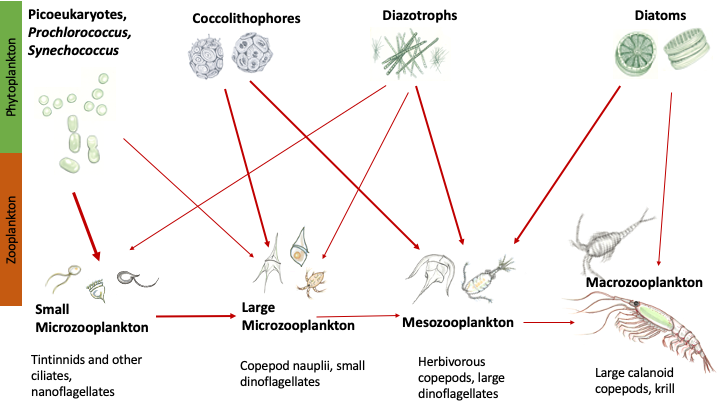

In [2]:
Image(filename='/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/just_food_web.png')

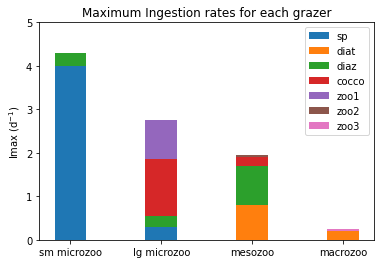

In [3]:
N = 4 # number of grazers

#grazees
sp = [4, 0.3, 0, 0]
diat = [0, 0, 0.8, 0.2]
diaz = [0.3, 0.25, 0.9, 0]
cocco = [0, 1.3, 0.2, 0]
zoo1 = [0,0.9,0,0]
zoo2 = [0,0,0.04,0]
zoo3 = [0,0,0,0.04]

ind = np.arange(N)    # the x locations for the grazers
width = 0.35       # the width of the bars

bars2=np.add(sp, diat).tolist()
bars3=np.add(bars2, diaz).tolist()
bars4=np.add(bars3, cocco).tolist()
bars5=np.add(bars4, zoo1).tolist()
bars6=np.add(bars5, zoo2).tolist()

p1 = plt.bar(ind, sp, width)
p2 = plt.bar(ind, diat, width, bottom=sp)
p3 = plt.bar(ind, diaz, width, bottom=bars2)
p4 = plt.bar(ind, cocco, width, bottom=bars3)
p5 = plt.bar(ind, zoo1, width, bottom=bars4)
p6 = plt.bar(ind, zoo2, width, bottom=bars5)
p7 = plt.bar(ind, zoo3, width, bottom=bars6)

plt.rcParams["figure.figsize"] = (10,7)
plt.ylabel('Imax (d$^{-1}$)')
plt.title('Maximum Ingestion rates for each grazer')
plt.xticks(ind, ('sm microzoo', 'lg microzoo', 'mesozoo', 'macrozoo'))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ('sp', 'diat', 'diaz', 'cocco','zoo1','zoo2','zoo3'))
plt.ylim(0,5);

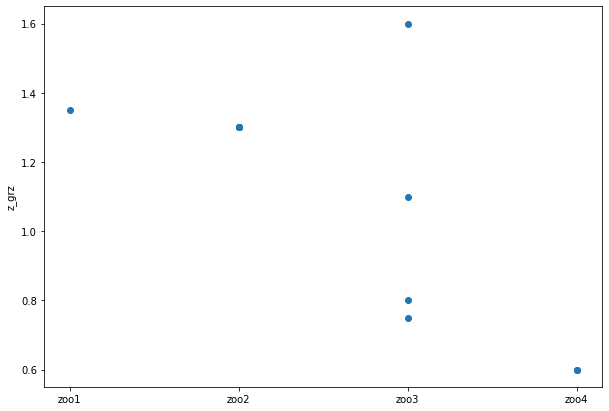

In [4]:
plt.scatter([1, 2,2,2,2, 3,3,3,3, 4,4],[1.35, 1.3,1.3,1.3,1.3, 1.1,0.8,0.75,1.6, 0.6,0.6])
plt.ylabel('z_grz')
plt.xticks([1, 2, 3, 4],
           ["zoo1", "zoo2", "zoo3", "zoo4"]);
#plt.rcParams["figure.figsize"] = (6,3);

### Define latest year and get the CESM data

In [5]:
start_yr = 32
num_years = 2
endyr = start_yr + num_years 
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
user = 'kristenk'

In [6]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 32 !
doing simulation year 33 !


In [7]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

In [8]:
cesm_mon_ds.POC_FLUX_100m

<xarray.DataArray 'POC_FLUX_100m' (time: 24, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(24, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1.171e+04 1.174e+04 ... 1.238e+04 1.241e+04
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     POC Flux at 100m
    units:         mmol/m^3 cm/s
    coordinates:   TLONG TLAT time
    grid_loc:      2110
    cell_methods:  time: mean

### Keep only the variables we need

In [9]:
variables = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf',
             'diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','CaCO3_PROD_zint','SiO2_PROD','POC_FLUX_100m',
             'coccoCaCO3','diatC', 'coccoC','spC','diazC','SALT',
             'PO4','Fe','NO3','SiO3','ALK','photoC_TOT_zint_100m',
            'zoo1C','zoo2C','zoo3C','zoo4C','x_graze_zoo1_zint','x_graze_zoo2_zint',
            'x_graze_zoo3_zint','x_graze_zoo4_zint','IFRAC','diaz_Nfix',
            'spChl','diatChl','diazChl','coccoChl'] 
coords = {'x':'TLONG','y':'TLAT'}

In [10]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [11]:
cesm_ann_ds=cesm_mon_ds.mean(dim='time')

#### World Ocean Atlas 2013

In [12]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [13]:
ds_woa['z_t'] = cesm_ann_ds.z_t

In [14]:
NO3_diff = cesm_ann_ds.NO3 - ds_woa.NO3
PO4_diff = cesm_ann_ds.PO4 - ds_woa.PO4
SiO3_diff = cesm_ann_ds.SiO3 - ds_woa.SiO3

In [15]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
area_m=area * 1.e-4
dz_m=ds_woa.dz * 0.01

In [16]:
rmse_global = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})

In [17]:
#help(esmlab.statistics)
rmse_global['NO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
rmse_global['PO4']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)

In [18]:
rmse_global.PO4.values

array([0.19067134, 0.1976176 , 0.21273124, 0.22696223, 0.23971597,
       0.24970618, 0.2579269 , 0.26319071, 0.26752536, 0.2710024 ,
       0.27097296, 0.26957299, 0.27132467, 0.26508874, 0.26188399,
       0.25515134, 0.24595662, 0.2411826 , 0.23475428, 0.2337272 ,
       0.22831635, 0.2291715 , 0.22138366, 0.21710945, 0.21672143,
       0.21836857, 0.22161816, 0.22499918, 0.22559957, 0.22611999,
       0.22616685, 0.22210425, 0.21466206, 0.20405556, 0.19499215,
       0.18055387, 0.17122531, 0.15675275, 0.13861221, 0.13237939,
       0.12869829, 0.13279814, 0.14090073, 0.13200853, 0.12386978,
       0.11357413, 0.10826432, 0.10112917, 0.09386687, 0.09243404,
       0.09080951, 0.08793067, 0.08436795, 0.07817192, 0.07540676,
       0.07650206, 0.07835615, 0.07999946, 0.07604629, 0.06158714])

In [19]:
rmse_global.NO3.values

array([2.03807003, 2.11059902, 2.30831829, 2.5398395 , 2.75295161,
       2.88881498, 3.02593659, 3.13644425, 3.20121421, 3.26650952,
       3.24366519, 3.26057526, 3.3485668 , 3.34444173, 3.390844  ,
       3.40849864, 3.41224804, 3.47788694, 3.49294064, 3.58442162,
       3.66621335, 3.83791764, 3.935482  , 4.13947236, 4.41749135,
       4.7044867 , 4.98851899, 5.22358499, 5.36669545, 5.50643148,
       5.55104115, 5.51078197, 5.37426081, 5.21337202, 4.92870636,
       4.39552198, 3.75081199, 2.9595701 , 2.28824821, 2.00892607,
       1.88474405, 1.99688067, 2.09948559, 2.04875053, 1.87289209,
       1.64068197, 1.43228534, 1.27239737, 1.17389527, 1.14958964,
       1.13756424, 1.11236307, 1.0368151 , 0.93851085, 0.89610149,
       0.94489519, 0.89748702, 0.87273749, 0.83996307, 0.87130718])

In [20]:
rmse_global.SiO3.values

array([6.96984526, 7.15233743, 7.14067989, 7.17901224, 7.24505448,
       7.30526438, 7.56522194, 7.79107991, 8.1634171 , 8.48631289,
       8.78629846, 9.13594285, 9.40158419, 9.42820931, 9.35641084,
       9.19368144, 9.00559265, 8.87740686, 8.64204382, 8.5195902 ,
       8.29882489, 8.15532233, 7.85847842, 7.64926174, 7.52456404,
       7.41994413, 7.36798339, 7.34377229, 7.26614732, 7.24983224,
       7.39532368, 7.5208077 , 7.61399631, 7.79557815, 8.05642611,
       8.2139311 , 8.22834444, 7.93039453, 7.57207296, 7.2484363 ,
       6.40585787, 5.8038249 , 5.67300456, 5.43116942, 5.62920522,
       5.8613807 , 6.37356046, 6.70298146, 7.05740404, 7.2755966 ,
       7.32827464, 7.19002351, 6.82278596, 6.26254594, 6.24057703,
       6.62117989, 6.55553597, 6.34600771, 5.6653855 , 5.37421547])

#### Surface nutrients

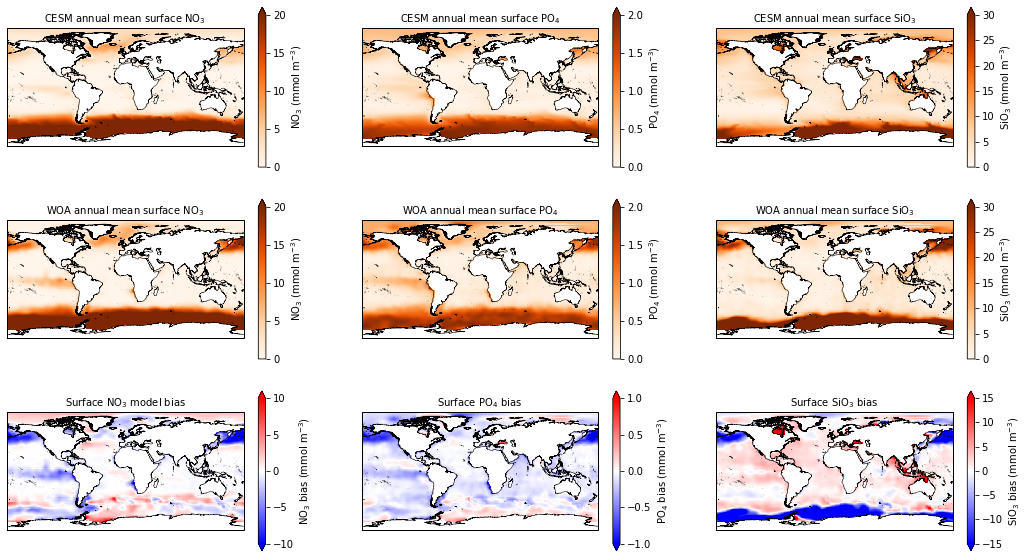

In [21]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



### Global nutrient profiles

In [22]:
ds_glb = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb['NO3']= esmlab.weighted_mean(cesm_ann_ds['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['PO4']= esmlab.weighted_mean(cesm_ann_ds['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['SiO3']= esmlab.weighted_mean(cesm_ann_ds['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

In [23]:
ds_glb_woa = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

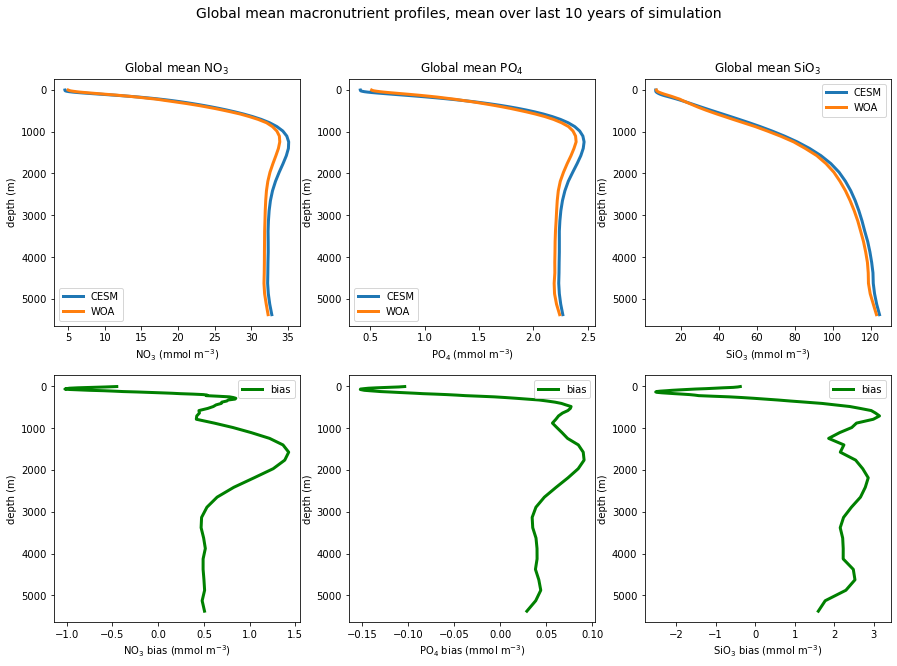

In [24]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



### Phytoplankton nutrient limitation at surface

In [25]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_ann_ds.sp_P_lim_surf, cesm_ann_ds.sp_Fe_lim_surf,cesm_ann_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_ann_ds.diat_P_lim_surf, cesm_ann_ds.diat_Fe_lim_surf, cesm_ann_ds.diat_N_lim_surf, cesm_ann_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_ann_ds.diaz_P_lim_surf, cesm_ann_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_ann_ds.cocco_P_lim_surf, cesm_ann_ds.cocco_Fe_lim_surf, cesm_ann_ds.cocco_N_lim_surf, cesm_ann_ds.cocco_C_lim_surf),dim='nutrient')

In [26]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

In [27]:
most_lim_sp = most_lim_sp.squeeze()
most_lim_diat = most_lim_diat.squeeze()
most_lim_diaz = most_lim_diaz.squeeze()
most_lim_cocco = most_lim_cocco.squeeze()

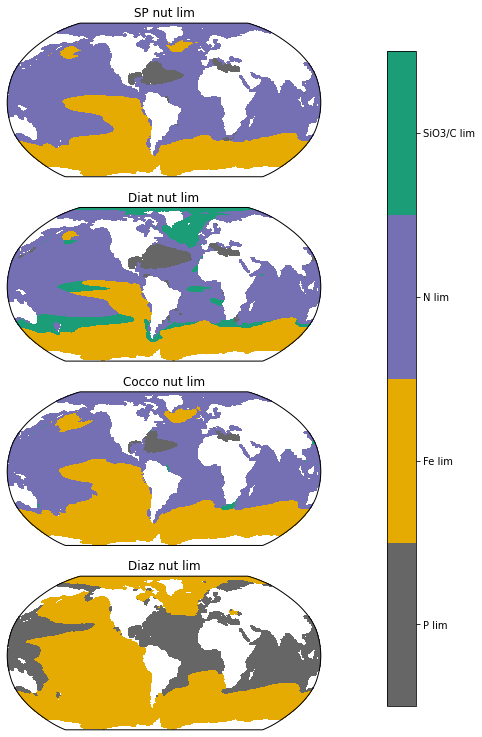

In [28]:
fig = plt.figure(figsize=(8,13))

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diat.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_sp.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_cocco.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diaz.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Monthly nutrient limitations

In [29]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_mon_ds.sp_P_lim_surf, cesm_mon_ds.sp_Fe_lim_surf,cesm_mon_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_mon_ds.diat_P_lim_surf, cesm_mon_ds.diat_Fe_lim_surf, cesm_mon_ds.diat_N_lim_surf, cesm_mon_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_mon_ds.diaz_P_lim_surf, cesm_mon_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_mon_ds.cocco_P_lim_surf, cesm_mon_ds.cocco_Fe_lim_surf, cesm_mon_ds.cocco_N_lim_surf, cesm_mon_ds.cocco_C_lim_surf),dim='nutrient')

In [30]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

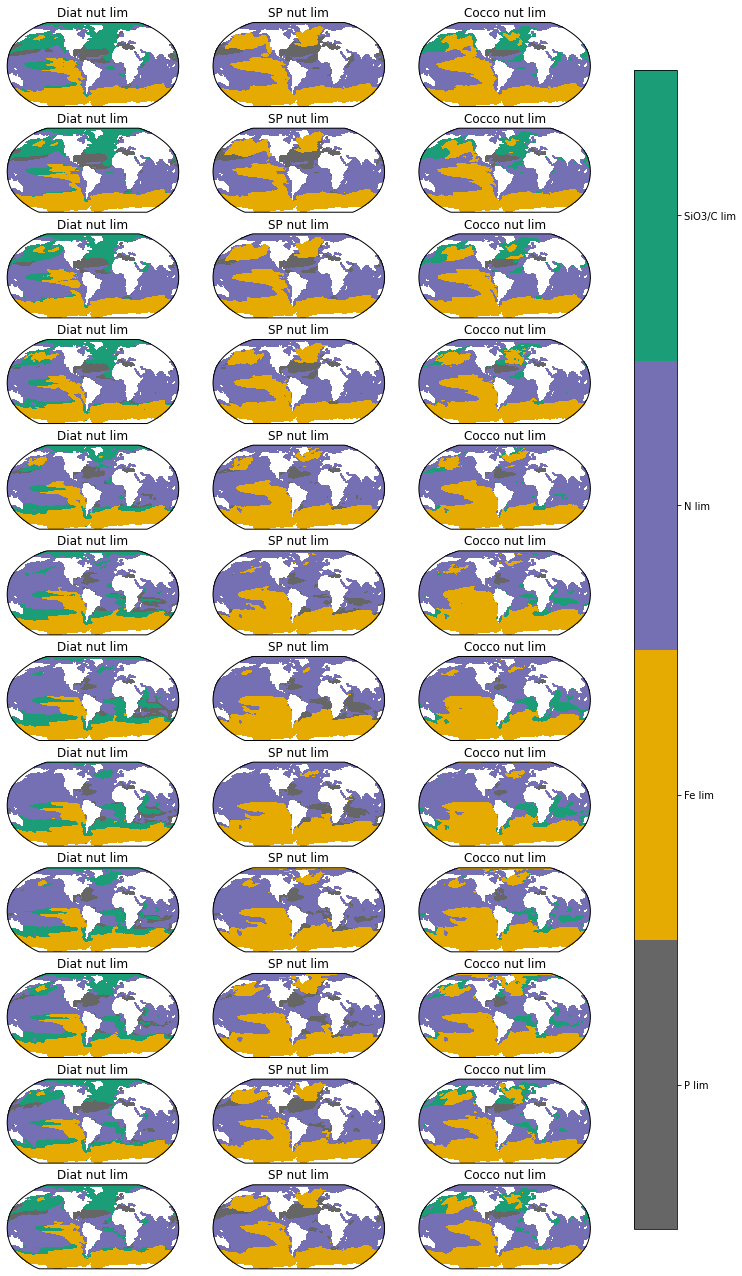

In [31]:
fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    
    #row 1 Jan
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diat nut lim', fontsize=12)
    pc=ax.pcolormesh(lons, lats, most_lim_diat.isel(time=ts).where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('SP nut lim', fontsize=12)
    pc=ax.pcolormesh(lons, lats, most_lim_sp.isel(time=ts).where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Cocco nut lim', fontsize=12)
    pc=ax.pcolormesh(lons, lats, most_lim_cocco.isel(time=ts).where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Look at phyto carbon pools

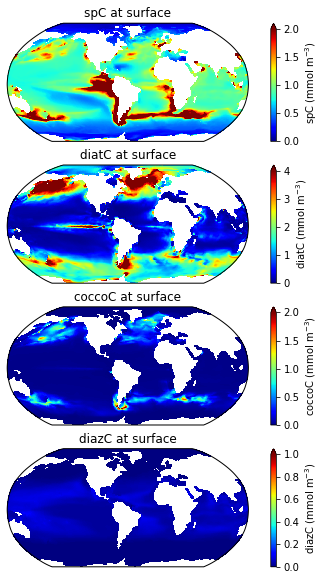

In [32]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diatC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.spC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diazC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Phytoplankton production maps

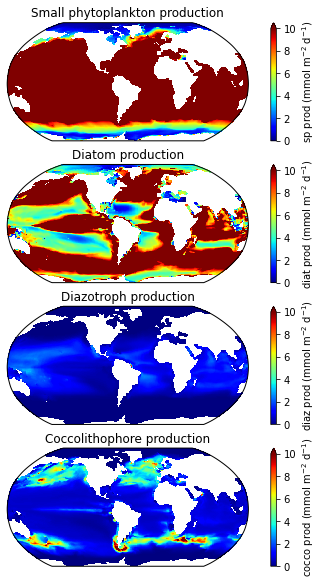

In [33]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
tmp = cesm_ann_ds.photoC_sp_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
tmp = cesm_ann_ds.photoC_diat_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
tmp = cesm_ann_ds.photoC_diaz_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
tmp = cesm_ann_ds.photoC_cocco_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)')

### Look at percent phytoC

In [34]:
phytoC = cesm_ann_ds.spC + cesm_ann_ds.diatC + cesm_ann_ds.diazC + cesm_ann_ds.coccoC
perc_sp = cesm_ann_ds.spC / (phytoC) * 100.
perc_cocco = cesm_ann_ds.coccoC / (phytoC) * 100.
perc_diat = cesm_ann_ds.diatC / (phytoC) * 100.
perc_diaz = cesm_ann_ds.diazC / (phytoC) * 100.

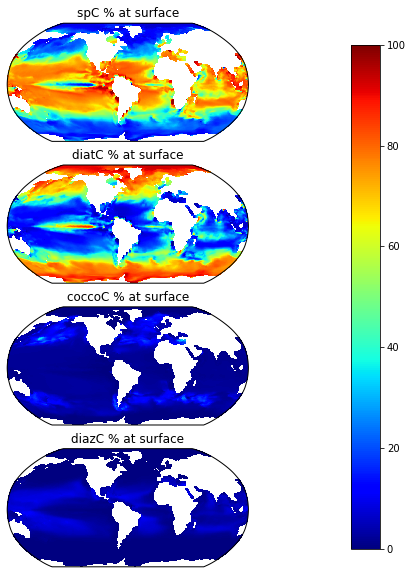

In [35]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_cocco.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_diat.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_sp.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_diaz.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax)

### Plot zooC

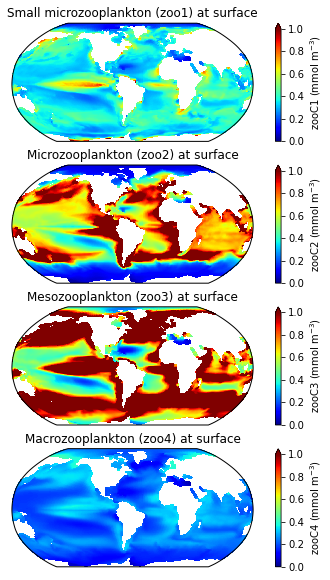

In [36]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small microzooplankton (zoo1) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo1C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC1 (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo2) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo2C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC2 (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton (zoo3) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo3C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC3 (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo4) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo4C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC4 (mmol m$^{-3}$)')

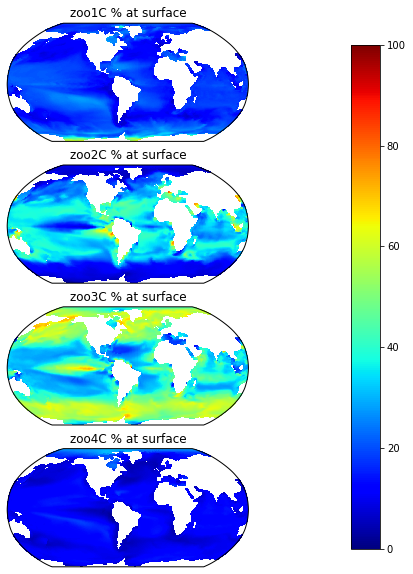

In [37]:
zooC = cesm_ann_ds.zoo1C + cesm_ann_ds.zoo2C + cesm_ann_ds.zoo3C + cesm_ann_ds.zoo4C
perc_zoo1 = cesm_ann_ds.zoo1C / (zooC) * 100.
perc_zoo2 = cesm_ann_ds.zoo2C / (zooC) * 100.
perc_zoo3 = cesm_ann_ds.zoo3C / (zooC) * 100.
perc_zoo4 = cesm_ann_ds.zoo4C / (zooC) * 100.

fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo1C % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_zoo1.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo2C % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_zoo2.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo3C % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_zoo3.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4C % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_zoo4.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax)

In [38]:
zoo1_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo1C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo1_biomass = zoo1_biomass * 10. #mmol
zoo1_biomass = zoo1_biomass.sum(dim='z_t_150m')
zoo1_biomass = zoo1_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo1 biomass is ', zoo1_biomass, ' Pg C.')
zoo2_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo2C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo2_biomass = zoo2_biomass * 10. #mmol
zoo2_biomass = zoo2_biomass.sum(dim='z_t_150m')
zoo2_biomass = zoo2_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo2 biomass is ', zoo2_biomass, ' PgC')
print('Total microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is ', zoo1_biomass + zoo2_biomass, ' Pg C.')
zoo3_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo3C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo3_biomass = zoo3_biomass * 10. #mmol
zoo3_biomass = zoo3_biomass.sum(dim='z_t_150m')
zoo3_biomass = zoo3_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo3 biomass is ', zoo3_biomass, ' Pg C. Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013)')
zoo4_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo4C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo4_biomass = zoo4_biomass * 10. #mmol
zoo4_biomass = zoo4_biomass.sum(dim='z_t_150m')
zoo4_biomass = zoo4_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo4 biomass is ', zoo4_biomass, ' Pg C. Macrozooplankton biomass is estimated to be 0.02 Pg C (Moriarty et al., 2013).')

zoo1 biomass is  0.13223149741156584  Pg C.
zoo2 biomass is  0.22617903846557802  PgC
Total microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is  0.3584105358771439  Pg C.
zoo3 biomass is  0.3791533395568065  Pg C. Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013)
zoo4 biomass is  0.12068681868834844  Pg C. Macrozooplankton biomass is estimated to be 0.02 Pg C (Moriarty et al., 2013).


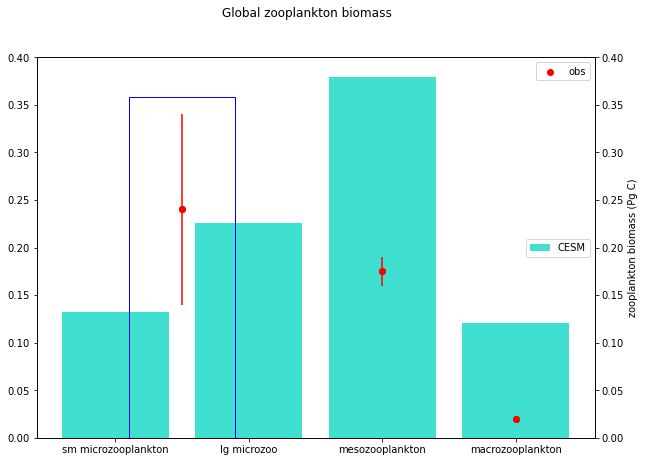

In [39]:
fig, ax = plt.subplots()
labels=['sm microzooplankton','lg microzoo','mesozooplankton','macrozooplankton']
ind=[0,1,2,3]
ind2=[0.5,2,3]
obs=[0.24,0.175,0.02]
obserr=[0.1,0.015,0]
vals=[zoo1_biomass,zoo2_biomass,zoo3_biomass,zoo4_biomass]

plt.suptitle('Global zooplankton biomass')
ax.bar(ind, vals,label='CESM',color='turquoise')
ax.bar(0.5,zoo1_biomass+zoo2_biomass,edgecolor='blue',fill=False)
ax.legend(loc='center right')
ax.set_ylim(0,0.4)
ax2 = ax.twinx()
ax2.scatter(ind2, obs,color='red',marker='o', label='obs')
ax2.errorbar(ind2, obs,yerr=obserr,color='red',fmt='o')
ax2.set_ylim(0,0.4)
ax2.set_ylabel('zooplankton biomass (Pg C)')
ax2.legend()
plt.xticks(ind, labels,rotation=45, ha='right');

### Plot zooplankton production maps

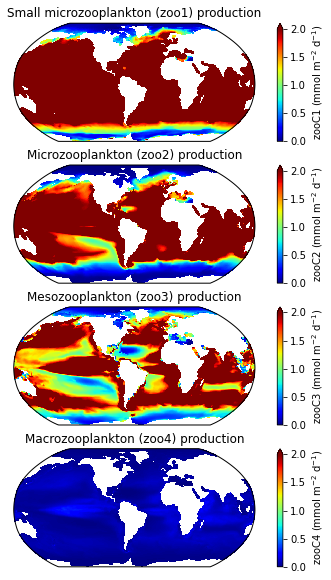

In [40]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small microzooplankton (zoo1) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo1_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC1 (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo2) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo2_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC2 (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton (zoo3) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo3_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC3 (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo4) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo4_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC4 (mmol m$^{-2}$ d$^{-1}$)')

### NPP

In [41]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [42]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    photoC_diat_zint   float64 19.09
    photoC_sp_zint     float64 36.47
    photoC_diaz_zint   float64 1.157
    photoC_cocco_zint  float64 2.273
    photoC_TOT_zint    float64 59.0

### Chlorophyll comparison

In [43]:
chl_file = '/glade/work/kristenk/satellite_data/Chl_cumulative_mean/A20021852020182.L3m_CU_CHL_chlor_a_9km.nc'
ds_chl = xr.open_dataset(chl_file, decode_times=False)
#units are mg/m3
tot_chl = cesm_ann_ds.spChl.isel(z_t_150m=0) + cesm_ann_ds.diatChl.isel(z_t_150m=0) + cesm_ann_ds.coccoChl.isel(z_t_150m=0) + cesm_ann_ds.diazChl.isel(z_t_150m=0)

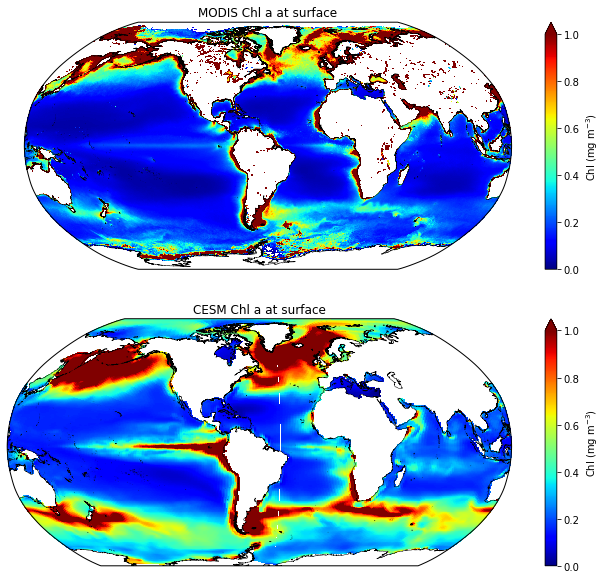

In [44]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MODIS Chl a at surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_chl.lon.values, ds_chl.lat.values, ds_chl.chlor_a, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl a at surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, tot_chl, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')


### Zooplankton production (zoo grazing - zoo respiration)
#### Should be ~25% of NPP

In [45]:
variables = [f'x_graze_{zoo}_zint' for zoo in ['zoo1', 'zoo2', 'zoo3','zoo4']]

ds_zooglb = xr.Dataset()
for v in variables:
    ds_zooglb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_zooglb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_zooglb[v] = ds_zooglb[v] * nmols_to_PgCyr        
    ds_zooglb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_zooglb = ds_zooglb.compute()
ds_zooglb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    x_graze_zoo1_zint  float64 8.126
    x_graze_zoo2_zint  float64 3.458
    x_graze_zoo3_zint  float64 3.307
    x_graze_zoo4_zint  float64 0.1233

In [46]:
## calculate % zoo prod of NPP 
npp_tot=ds_glb.photoC_TOT_zint.values
zoo_prod=ds_zooglb.x_graze_zoo1_zint.values + ds_zooglb.x_graze_zoo2_zint.values + ds_zooglb.x_graze_zoo3_zint.values
print('• Zooplankton production is ', (zoo_prod/npp_tot * 100.), '% of NPP.')
## calculate % microzooplankton (zoo1) prod of total zoo prod
micro_prod=ds_zooglb.x_graze_zoo1_zint.values
print('• Small microzooplankton production is ', (micro_prod/zoo_prod * 100.), '% of total zooplankton production.')
micro_prod=ds_zooglb.x_graze_zoo1_zint.values + ds_zooglb.x_graze_zoo2_zint.values
print('• Microzooplankton production is ', (micro_prod/zoo_prod * 100.), '% of total zooplankton production.')
print('• Microzooplankton production is ', (micro_prod/npp_tot * 100.), '% of NPP.')

• Zooplankton production is  25.23871473030546 % of NPP.
• Small microzooplankton production is  54.569279404438554 % of total zooplankton production.
• Microzooplankton production is  77.79138513290906 % of total zooplankton production.
• Microzooplankton production is  19.63354577844817 % of NPP.


### Z-ratio (Stock & Dunne, 2010)

In [47]:
file='/glade/work/kristenk/z-ratio/z_ratio_POPgrid.nc'
ds_zratio=xr.open_dataset(file,decode_times=False,decode_coords=False)

In [48]:
z_ratio = cesm_ann_ds.x_graze_zoo3_zint / cesm_ann_ds.photoC_TOT_zint
#z_ratio = (cesm_ann_ds.x_graze_zoo3_zint + cesm_ann_ds.x_graze_zoo4_zint) / cesm_ann_ds.photoC_TOT_zint

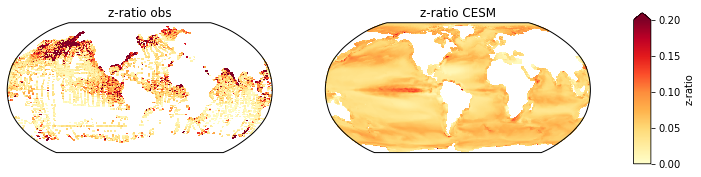

In [49]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio obs', fontsize=12)
tmp = ds_zratio.z_ratio
pc=ax.pcolormesh(lons, lats, tmp, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio CESM', fontsize=12)
tmp = z_ratio
pc=ax.pcolormesh(lons, lats, tmp, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='z-ratio')

In [50]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### MAREDAT Micozooplankton/zoo1+zoo2 comparison

In [51]:
file = '/glade/work/kristenk/MAREDAT/microzooplankton/mean_fields/MAREDAT_microzoo_means.nc'
maredat_microzoo_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

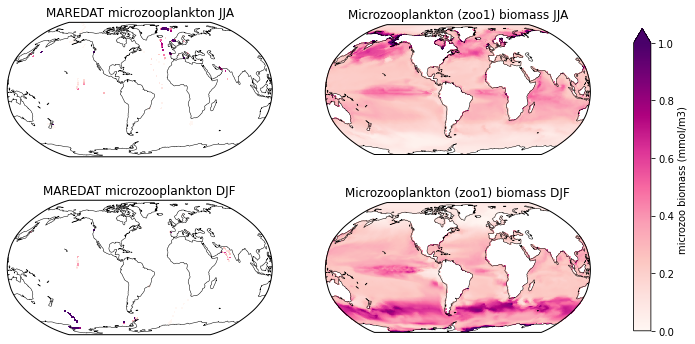

In [52]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton JJA', fontsize=12)
tmp = maredat_microzoo_ds.JJA_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo1) biomass JJA', fontsize=12)
tmp = cesm_mon_ds.zoo1C.isel(time=[5,6,7],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
tmp2 = cesm_mon_ds.zoo2C.isel(time=[5,6,7],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
#tmp=tmp+tmp2
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton DJF', fontsize=12)
tmp = maredat_microzoo_ds.DJF_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo1) biomass DJF', fontsize=12)
tmp = cesm_mon_ds.zoo1C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
tmp2 = cesm_mon_ds.zoo2C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
#tmp = tmp + tmp2
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max',label='microzoo biomass (mmol/m3)');

In [53]:
ifrac = cesm_mon_ds.IFRAC.isel(time=[11,0,1]).mean(dim='time') #.where(cesm_ann_ds.IFRAC > 0)

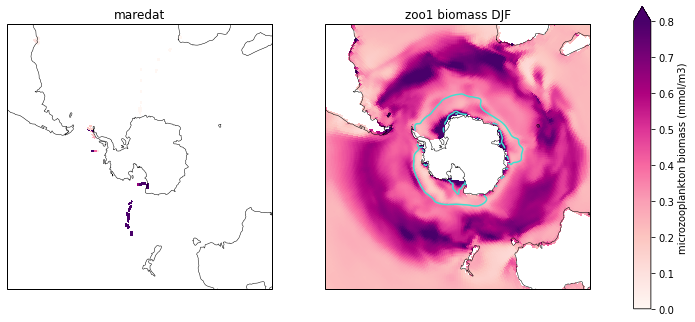

In [54]:
fig = plt.figure(figsize=(12,6))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('maredat')
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, 
                 maredat_microzoo_ds.DJF_mean_top100m/12.011, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=1, 
                 cmap='RdPu',
                 transform=ccrs.PlateCarree())

########################
tmp = cesm_mon_ds.zoo1C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
lon,lat,field = adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]

lon,lat,field2 = adjust_pop_grid(lons, lats, ifrac)
lons_sh2 = lon[sh, :]
lats_sh2 = lat[sh, :]
field2 = field2[sh, :]

ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('zoo1 biomass DJF', fontsize=12)
pc=ax.pcolormesh(lons_sh, lats_sh, 
                 field, 
                 vmin=0, vmax=0.8, 
                 cmap='RdPu',
                 transform=ccrs.PlateCarree())
pci=ax.contour(lons_sh2, lats_sh2, 
                 field2, 
                 levels=[0.1], 
                 colors='turquoise',
                 transform=ccrs.PlateCarree(), label='10% ice cover'
              )

ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='microzooplankton biomass (mmol/m3)');
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# fig.colorbar(pci, cax=cbar_ax,extend='max', label='IFRAC');

### COPEPOD comparison (Mesozooplankton/zoo3)

In [55]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

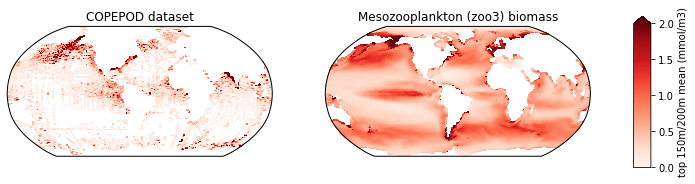

In [56]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
tmp = ds_copepod.copepod_C
pc=ax.pcolormesh(lons, lats, tmp, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton (zoo3) biomass', fontsize=12)
tmp = cesm_ann_ds.zoo3C.mean(dim='z_t_150m')
pc=ax.pcolormesh(lons, lats, tmp, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol/m3)')

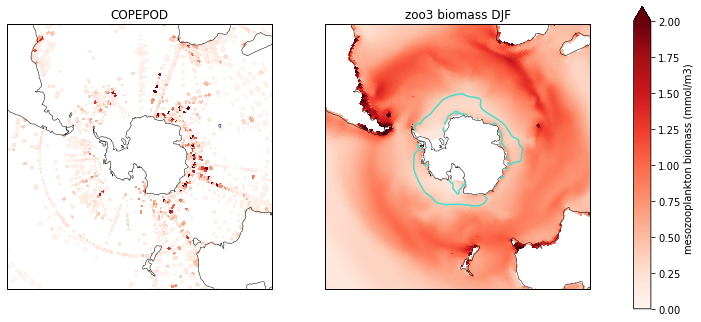

In [57]:
fig = plt.figure(figsize=(12,6))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('COPEPOD')
tmp = ds_copepod.copepod_C
lon,lat,field = adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lons_sh, lats_sh, field, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())

########################
tmp = cesm_ann_ds.zoo3C.mean(dim='z_t_150m')
lon,lat,field = adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]

lon,lat,field2 = adjust_pop_grid(lons, lats, ifrac)
lons_sh2 = lon[sh, :]
lats_sh2 = lat[sh, :]
field2 = field2[sh, :]

ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('zoo3 biomass DJF', fontsize=12)
pc=ax.pcolormesh(lons_sh, lats_sh, 
                 field, 
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())
pci=ax.contour(lons_sh2, lats_sh2, 
                 field2, 
                 levels=[0.1], 
                 colors='turquoise',
                 transform=ccrs.PlateCarree(), label='10% ice cover'
              )

ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='mesozooplankton biomass (mmol/m3)');
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# fig.colorbar(pci, cax=cbar_ax,extend='max', label='IFRAC');

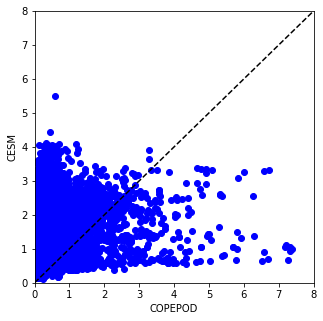

In [58]:
#### make line plots plotting mesozooplankton abundance versus COPEPOD database
one2one = np.array([0, 8])
x_vals = ds_copepod.copepod_C.values
x_vals = x_vals.flatten()

fig = plt.figure(figsize=(5,5))   
#set up the vals
y_vals = cesm_ann_ds.zoo3C.isel(z_t_150m=0).values
y_vals = y_vals.flatten()
ax = fig.add_subplot(1,1,1)
ax.scatter(x_vals,y_vals,color='blue',marker='o',
           label='control')
ax.set_ylabel('CESM')
ax.set_xlabel('COPEPOD')
ax.set_ylim(0,8)
ax.set_xlim(0,8)
ax.plot(one2one,one2one,color='black',linestyle='--')

### Macrozooplankton comparison

In [59]:
file = '/glade/work/kristenk/MAREDAT/macrozooplankton/mean_fields/MAREDAT_macrozoo_means.nc'
maredat_macrozoo_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

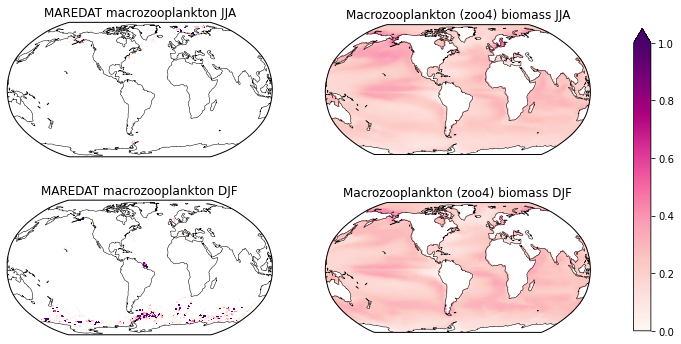

In [60]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT macrozooplankton JJA', fontsize=12)
tmp = maredat_macrozoo_ds.JJA_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_macrozoo_ds.LONGITUDE, maredat_macrozoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo4) biomass JJA', fontsize=12)
tmp = cesm_mon_ds.zoo4C.isel(time=[5,6,7],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT macrozooplankton DJF', fontsize=12)
tmp = maredat_macrozoo_ds.DJF_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_macrozoo_ds.LONGITUDE, maredat_macrozoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo4) biomass DJF', fontsize=12)
tmp = cesm_mon_ds.zoo4C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max');

In [61]:
ifrac = cesm_mon_ds.IFRAC.isel(time=[11,0,1]).mean(dim='time') #.where(cesm_ann_ds.IFRAC > 0)

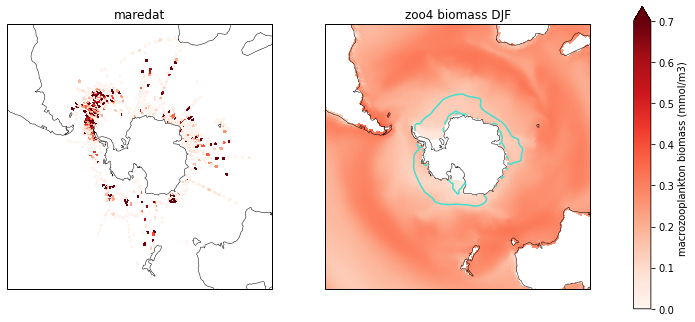

In [62]:
fig = plt.figure(figsize=(12,6))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('maredat')
pc=ax.pcolormesh(maredat_macrozoo_ds.LONGITUDE, maredat_macrozoo_ds.LATITUDE, 
                 maredat_macrozoo_ds.DJF_mean_top100m/12.011, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=1, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())

########################
tmp = cesm_mon_ds.zoo4C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
lon,lat,field = adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]

lon,lat,field2 = adjust_pop_grid(lons, lats, ifrac)
lons_sh2 = lon[sh, :]
lats_sh2 = lat[sh, :]
field2 = field2[sh, :]

ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('zoo4 biomass DJF', fontsize=12)
pc=ax.pcolormesh(lons_sh, lats_sh, 
                 field, 
                 vmin=0, vmax=0.7, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())
pci=ax.contour(lons_sh2, lats_sh2, 
                 field2, 
                 levels=[0.1], 
                 colors='turquoise',
                 transform=ccrs.PlateCarree(), label='10% ice cover'
              )

ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='macrozooplankton biomass (mmol/m3)')
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# fig.colorbar(pci, cax=cbar_ax,extend='max', label='IFRAC');

### Calcification

In [63]:
## GLOBALLY integrated calcification; observation-based estimates range from 0.8 to 2.4 Pg CaCO3 per year 
## (Feely et al., 2004, Maranon et al., 2016, Smith et al., 2016, Balch et al., 2007, Iglesias-Rodriguez et al., 2002)
ds_glb['CaCO3_PROD_zint'] = esmlab.statistics.weighted_sum(cesm_ann_ds['CaCO3_PROD_zint'], weights=area, dim=['nlat', 'nlon'])
ds_glb['CaCO3_PROD_zint'] = ds_glb['CaCO3_PROD_zint'] * nmols_to_PgCyr
ds_glb['CaCO3_PROD_zint'].values
print('Globally integrated calcification is',ds_glb['CaCO3_PROD_zint'].values, 'Pg C per year')
print('(should be between 0.6 to 2.4 Pg C per year)')

Globally integrated calcification is 0.7347986994371424 Pg C per year
(should be between 0.6 to 2.4 Pg C per year)


In [64]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)

#convert to mmol/m3 from mg/m3
ds_pic['PIC']=ds_pic.PIC / 12.011

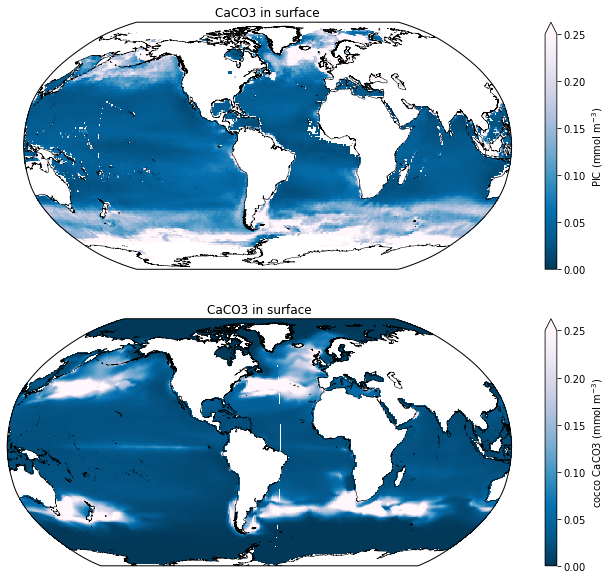

In [65]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.PIC, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='PIC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoCaCO3.isel(z_t_150m=0), cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco CaCO3 (mmol m$^{-3}$)')


### cocco PIC/POC

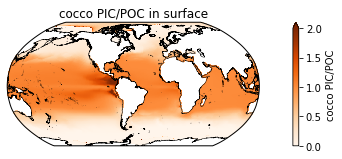

In [66]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('cocco PIC/POC in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoCaCO3.isel(z_t_150m=0)/cesm_ann_ds.coccoC.isel(z_t_150m=0), cmap='Oranges',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco PIC/POC')


### N fixation

In [67]:
#global integral
tmp = cesm_ann_ds['diaz_Nfix'] * 10. #multiply by the thickness of each layer in the top 150m (10m)
tmp = tmp.sum(dim='z_t_150m') # unit is mmol/m2/s
ds_glb['diaz_Nfix'] = esmlab.statistics.weighted_sum(tmp, weights=area_m, dim=['nlat', 'nlon'])
ds_glb['diaz_Nfix'] = ds_glb['diaz_Nfix'] * 86400. * 365. * 0.001 * 14. * 1e-12 #convert to Tg N / yr
ds_glb['diaz_Nfix'].values
print('Globally integrated marine nitrogen fixation is',ds_glb['diaz_Nfix'].values, 'Tg N per year')
print('(should be between ~163.2 (range between 125.6 and 222.9 Tg N per year; Wang et al., 2019)')

Globally integrated marine nitrogen fixation is 195.9600329084261 Tg N per year
(should be between ~163.2 (range between 125.6 and 222.9 Tg N per year; Wang et al., 2019)


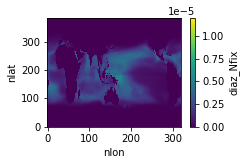

In [68]:
tmp.plot(figsize=(3,2))

### Alkalinity

In [69]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_grid/GLODAP_POPgrid_v2.nc'
ds_glodap = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_glodap['z_t']=cesm_ann_ds.z_t

In [70]:
rmse_global['ALK']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.ALK, ds_glodap.ALK, dim=['nlat', 'nlon'], weights=area)
rmse_global.ALK.values

array([42.94666944, 39.75836815, 40.21191971, 36.59932816, 35.88905501,
       23.21898616, 21.98163793, 21.39749367, 19.84137644, 17.88305758,
       17.39980447, 16.89760505, 16.67853923, 16.07002774, 15.60905296,
       14.98373134, 14.3335934 , 13.88269387, 13.60645867, 13.55359462,
       13.00929158, 12.51493324, 12.14950467, 11.92797219, 11.58901639,
       11.43930559, 11.35203741, 11.01938291, 10.81124738, 10.76713967,
       10.83230917, 10.68307826, 10.8259039 , 10.77986461, 10.7536912 ,
       10.42679061, 10.11927218,  9.5315349 ,  9.06673433,  8.80639992,
        8.5011934 ,  7.92438821,  6.90696761,  5.87750375,  5.46544989,
        5.16016866,  4.85430176,  5.09607284,  5.23866628,  5.53657604,
        5.56977278,  5.83969025,  6.00276877,  6.86410544,  7.11499997,
        7.9634384 ,  8.8535318 ,  9.93991424,  9.17557443,  9.7599698 ])

In [71]:
ALK_diff = cesm_ann_ds.ALK - ds_glodap.ALK

In [ ]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))

#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface Alk', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.ALK.isel(z_t=0), cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface Alk', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_glodap.ALK.isel(z_t=0), cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='Alk (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface Alk model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ALK_diff.isel(z_t=0), vmin=-100, vmax=100, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='Alk bias (mmol m$^{-3}$)')

### Global POC export

In [ ]:
ds_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(cesm_ann_ds['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])
ds_glb['POC_FLUX_100m'] = ds_glb['POC_FLUX_100m'] * nmols_to_PgCyr
ds_glb['POC_FLUX_100m'].values
print('Globally integrated POC flux is',ds_glb['POC_FLUX_100m'].values, 'Pg C per year')

### Export ratio

In [ ]:
#plot E-RATIO
eratio = cesm_ann_ds.POC_FLUX_100m/cesm_ann_ds.photoC_TOT_zint_100m

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM e-ratio at 100m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 eratio, cmap='Greens',
                  vmin=0, vmax=0.25, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='export ratio')
